In [51]:
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)
import json

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    roc_auc_score
)

import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns




# Target

In [52]:
def get_target(input_df, ticker):
    df = input_df.copy()
    df["Target"] = (df[f"Close_{ticker}"].shift(-1) > df[f"Close_{ticker}"]).astype(int)
    df.dropna(inplace=True)
    return df

# Target TBM ( Triple Barrier Method)

In [53]:
def get_tbm_target(df, ticker, horizon=5, pt_sl=[1.3,1]):
    df = df.copy()
    close = df[f'Close_{ticker}']
    
    log_ret = np.log(close / close.shift(1))
    volatility = log_ret.rolling(window=20).std()
    
    targets = pd.Series(index=df.index, dtype=float)
    
    for i in range(len(df) - horizon):
        price_start = close.iloc[i]
        current_vol = volatility.iloc[i] ### dynamic barrier for each day
        
        upper_barrier = price_start * (1 + current_vol * pt_sl[0])
        lower_barrier = price_start * (1 - current_vol * pt_sl[1])
        
        future_prices = close.iloc[i+1 : i+ 1 + horizon]
        
        targets.iloc[i] = 0
        
        for price_future in future_prices:
            if price_future >= upper_barrier:
                targets.iloc[i] = 1 # profit taking hit
                break
            elif price_future <= lower_barrier:
                targets.iloc[i] = -1 # stop loss hit
                break
    df['Target'] = targets
    return df.dropna(subset=['Target'])

# Model: Ensemble (Voting Soft)
### With optuna to optimized

In [54]:
def build_ensemble_model_vote(X_train, y_train):
    def objective(trial):
        # for Random Forest
        rf_n_estimators = trial.suggest_int("rf_n_estimators", 50, 200)
        rf_max_depth = trial.suggest_int("rf_max_depth", 3, 10)
        
        # for XGBoost
        xgb_learning_rate = trial.suggest_float("xgb_learning_rate", 0.01, 0.2, log=True)
        xgb_max_depth = trial.suggest_int("xgb_max_depth", 2, 6)
        
        # for SVM
        svm_c = trial.suggest_float("svm_c", 0.1, 10.0, log=True)
        
        lr_pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("lr", LogisticRegression(max_iter=1000,
                    solver='lbfgs',
                    #multi_class='multinomial',
                    random_state=42))
    ])
        rf_pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("rf", RandomForestClassifier(
            n_estimators= rf_n_estimators,
            max_depth= rf_max_depth,
            min_samples_leaf=10,
            class_weight='balanced',
            random_state=42,
            n_jobs=-1
        ))
    ])  
        svm_pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("svc", SVC(
            kernel="rbf",
            C=svm_c,
            gamma="scale",
            class_weight='balanced',
            probability=True,
            random_state=42
        ))
    ])
        
        xgb_pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("xgb", XGBClassifier(
            n_estimators=100,
            max_depth= xgb_max_depth,
            learning_rate= xgb_learning_rate,
            random_state=42,
            n_jobs=-1,
            eval_metric="logloss"
        ))
    ])
        
        ensemble = VotingClassifier(
            estimators= [('lr', lr_pipe),('rf', rf_pipe), ('svm', svm_pipe), ('xgb', xgb_pipe)],
            voting='soft'
        )
        
        tscv = TimeSeriesSplit(n_splits=3)
        score = cross_val_score(ensemble, X_train, y_train, cv=tscv, scoring='precision_weighted')
        
        return score.mean()
    
    
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=40)
        
    best = study.best_params    
    lr_pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("lr", LogisticRegression(max_iter=1000,
                                  solver='lbfgs',
                                  #multi_class='multinomial',
                                  random_state=42))
    ])

    rf_pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("rf", RandomForestClassifier(
            n_estimators=best['rf_n_estimators'],
            max_depth=best['rf_max_depth'],
            min_samples_leaf=10,
            class_weight='balanced',
            random_state=42,
            n_jobs=-1
        ))
    ])

    svm_pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("svc", SVC(
            kernel="rbf",
            C=best['svm_c'],
            gamma="scale",
            class_weight='balanced',
            probability=True,
            random_state=42
        ))
    ])

    xgb_pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("xgb", XGBClassifier(
            n_estimators=100,
            max_depth=best['xgb_max_depth'],
            learning_rate=best['xgb_learning_rate'],
            random_state=42,
            n_jobs=-1,
            eval_metric="logloss"
        ))
    ])

    model = VotingClassifier(
        estimators=[
            ("lr", lr_pipeline),
            ("rf", rf_pipeline),
            ("svm", svm_pipeline),
            ("xgb", xgb_pipeline),
        ],
        voting="soft"
    )
    return model

### Sample Weights

In [55]:
def get_sample_weights(df, horizon=5):
    # create a binary matrix indicating which days are covered by which barrier
    num_rows = len(df)
    concurrency = np.zeros(num_rows)

    for i in range(num_rows - horizon):
        concurrency[i  : i + horizon] += 1

    uniqueness = 1.0 / np.maximum(concurrency, 1)

    weights = pd.Series(index=df.index, dtype=float)
    for i in range(num_rows - horizon):
        weights.iloc[i] = uniqueness[i : i + horizon].mean()
        
    return weights.fillna(0)

# Walk Forward validation with purging and embargo in validation


In [56]:
def walk_forward_validation_with_purging(
    df,
    features,
    model_version,
    target_col="Target",
    date_col="DATE",
    start_year=2010,
    first_train_end_year=2015,
    last_test_year=2023,
    horizon = 5,
    embargo_pct = 0.01
):

    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col])
    df = df.sort_values(date_col).reset_index(drop=True)

    all_y_true = []
    all_y_pred = []
    all_y_proba = []

    fold_rows = []

    sample_weights_all = get_sample_weights(df, horizon)
    
    for train_end_year in range(first_train_end_year, last_test_year):
        test_year = train_end_year + 1

        train_mask = (df[date_col].dt.year >= start_year) & (df[date_col].dt.year <= train_end_year)
        test_mask = (df[date_col].dt.year == test_year)

        train_df = df[train_mask]
        test_df = df[test_mask]

        # jeżeli jakiś rok nie ma danych to skip
        if len(train_df) < 200 or len(test_df) < 50:
            continue

        ## Purging
        train_df_purged = train_df.iloc[:-horizon]
        weights_train = sample_weights_all.loc[train_df_purged.index] 
        
        ## Embargo
        embargo_size = int(len(df) * embargo_pct)
        test_df_embargo = test_df.iloc[embargo_size:]
        
        if len(test_df_embargo) < 10: continue
        
        
        X_train = train_df_purged[features]
        y_train = train_df_purged[target_col]

        X_test = test_df_embargo[features]
        y_test = test_df_embargo[target_col]

        model = model_version(X_train,  y_train)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test) 

        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
        rec = recall_score(y_test, y_pred, average='weighted', zero_division=0)

        n_classes = len(np.unique(y_test))
        if n_classes == 2:
            auc = roc_auc_score(y_test, y_proba[:, 1])
        else:
            auc = roc_auc_score(
                y_test,
                y_proba,
                average="weighted",
                multi_class="ovr"
            )

        fold_rows.append({
            "train_end_year": train_end_year,
            "test_year": test_year,
            "n_train": len(train_df),
            "n_test": len(test_df),
            "accuracy": acc,
            "precision": prec,
            "recall": rec,
            "roc_auc": auc
        })

        all_y_true.extend(y_test.tolist())
        all_y_pred.extend(y_pred.tolist())
        all_y_proba.extend(y_proba.tolist())

    folds_df = pd.DataFrame(fold_rows)

    return folds_df, np.array(all_y_true), np.array(all_y_pred), np.array(all_y_proba)




# Block bootstrap

In [57]:
def block_bootstrap_accuracy(y_true, y_pred, block_size=20, n_bootstrap=1000, random_state=42):
    rng = np.random.default_rng(random_state)
    n = len(y_true)

    if n < block_size:
        raise ValueError("Za mało danych do bootstrapa w tej konfiguracji.")

    acc_samples = []

    for _ in range(n_bootstrap):
        sampled_idx = []

        while len(sampled_idx) < n:
            start = rng.integers(0, n - block_size + 1)
            block = list(range(start, start + block_size))
            sampled_idx.extend(block)

        sampled_idx = sampled_idx[:n]
        y_true_bs = y_true[sampled_idx]
        y_pred_bs = y_pred[sampled_idx]

        acc = accuracy_score(y_true_bs, y_pred_bs)
        acc_samples.append(acc)

    acc_samples = np.array(acc_samples)
    ci_low = np.percentile(acc_samples, 2.5)
    ci_high = np.percentile(acc_samples, 97.5)

    return acc_samples, ci_low, ci_high



# Walk_forward + Bootstrap

In [58]:


def run_stage4_for_ticker(df_raw, ticker, selected_features, model_version, target_type):
    if target_type == "tbm":
        df = get_tbm_target(df_raw, ticker)
    elif target_type == "binary":
        df = get_target(df_raw, ticker)
    result = {}

    selected_features = [f for f in selected_features if f in df.columns]

    folds_df, y_true_all, y_pred_all, y_proba_all = walk_forward_validation_with_purging(
        df=df,
        features=selected_features,
        model_version=model_version,
        target_col="Target",
        date_col="DATE",
        start_year=2010,
        first_train_end_year=2015,
        last_test_year=2023 
    )

    print("=" * 60)
    print(f" WALK-FORWARD RESULTS for {ticker}")
    metrics = ["accuracy", "precision", "recall", "roc_auc"]
    summary_mean = folds_df[metrics].mean()

    print("\n--- Summary ---")
    print(summary_mean.to_frame(name="Mean").T)
     
    print("\n--- Detailed Classification Report (Whole Period) ---")    
    print(classification_report(y_true_all, y_pred_all, zero_division=0))
    
    # Block Bootstrap
    acc_samples, ci_low, ci_high = block_bootstrap_accuracy(
        y_true=y_true_all,
        y_pred=y_pred_all,
        block_size=20,
        n_bootstrap=1000
    )

    print("\n" + "=" * 60)
    print(f" BLOCK BOOTSTRAP for {ticker}")
    print(f"95% CI accuracy: [{ci_low:.4f}, {ci_high:.4f}]")
    print(f"Bootstrap mean accuracy: {acc_samples.mean():.4f}")

    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_true_all, y_pred_all)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Loss (-1)', 'Neutral (0)', 'Profit (1)'],
                yticklabels=['Loss (-1)', 'Neutral (0)', 'Profit (1)'])
    plt.title(f'Confusion Matrix for {ticker}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    result[ticker] = {
        'summary': summary_mean.to_frame(name="Mean").T,
        'Bootstrap mean accuracy': acc_samples.mean(),
    }
    #file_path = f"../models_results/main_model_for_{ticker}_result.json"
    #with open(file_path, "w") as f:
        #json.dump(result, f, indent=2)
    

    return folds_df, acc_samples, result


# Example use (0/1 classification)

In [48]:
tickers = ["AAPL", "MSFT", "GOOGL"]

with open("../../selected_features/feature_dict_binary.json", "r") as f:
    feature_dict = json.load(f)

def get_all_features(df):
    return [c for c in df.columns if c not in ["DATE", "index", "Target"]]

output = {}
for share in tickers:
    data = pd.read_csv(f"../../data/all_data/all_{share}_data.csv")
    df_tmp = get_target(data, share)
    features_aapl = get_all_features(df_tmp)
    print(f"------{share}-----")
        
    selected_features = feature_dict[share]
    print(f"Selected features for {share}:")
    # print(f"Running for {share} with all features ({len(features_aapl)})")
    # run_stage4_for_ticker(data, share, features_aapl)
    print(f"Running for {share} with selected features ({len(selected_features)})")
    df, acc_smples, result = run_stage4_for_ticker(data, share, selected_features, model_version=build_ensemble_model_vote, target_type="binary")
    output[share] = result

def json_converter(obj):
    if isinstance(obj, (pd.DataFrame, pd.Series)):
        return obj.to_dict()
    if isinstance(obj, np.float64):
        return float(obj)
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    return str(obj)

with open("../results/best_result(binary).json", "w") as f:
        json.dump(output, f, indent=2, default=json_converter)

    

------AAPL-----
Selected features for AAPL:
Running for AAPL with selected features (22)


[W 2026-01-29 16:12:44,373] Trial 12 failed with parameters: {'rf_n_estimators': 101, 'rf_max_depth': 10, 'xgb_learning_rate': 0.07124739381322011, 'xgb_max_depth': 5, 'svm_c': 9.179186028239972} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/optuna/study/_optimize.py", line 205, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/var/folders/rs/rx9snnk15ss4_d166y1sz82h0000gn/T/ipykernel_34886/3880033101.py", line 62, in objective
    score = cross_val_score(ensemble, X_train, y_train, cv=tscv, scoring='precision_weighted')
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/_param_validation.py", line 218, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^

KeyboardInterrupt: 

# Example use (3 flags)

------AAPL-----
Selected features for AAPL:
Running for AAPL with selected features (21)
 WALK-FORWARD RESULTS for AAPL

--- Summary ---
      accuracy  precision   recall  roc_auc
Mean   0.38215   0.391091  0.38215   0.5358

--- Detailed Classification Report (Whole Period) ---
              precision    recall  f1-score   support

        -1.0       0.36      0.41      0.39       600
         0.0       0.28      0.27      0.28       321
         1.0       0.46      0.40      0.43       699

    accuracy                           0.38      1620
   macro avg       0.37      0.36      0.36      1620
weighted avg       0.39      0.38      0.38      1620


 BLOCK BOOTSTRAP for AAPL
95% CI accuracy: [0.3407, 0.4185]
Bootstrap mean accuracy: 0.3794


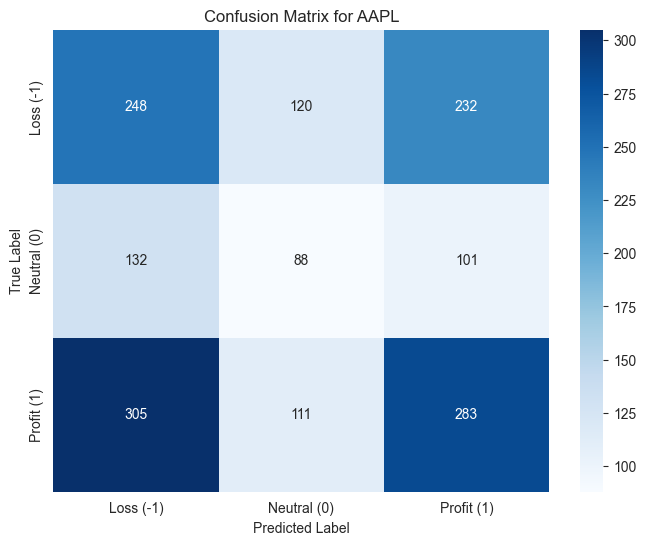

------MSFT-----
Selected features for MSFT:
Running for MSFT with selected features (17)
 WALK-FORWARD RESULTS for MSFT

--- Summary ---
      accuracy  precision    recall  roc_auc
Mean  0.389951   0.424569  0.389951  0.59333

--- Detailed Classification Report (Whole Period) ---
              precision    recall  f1-score   support

        -1.0       0.36      0.41      0.38       589
         0.0       0.30      0.31      0.31       356
         1.0       0.49      0.42      0.45       675

    accuracy                           0.39      1620
   macro avg       0.38      0.38      0.38      1620
weighted avg       0.40      0.39      0.39      1620


 BLOCK BOOTSTRAP for MSFT
95% CI accuracy: [0.3500, 0.4241]
Bootstrap mean accuracy: 0.3881


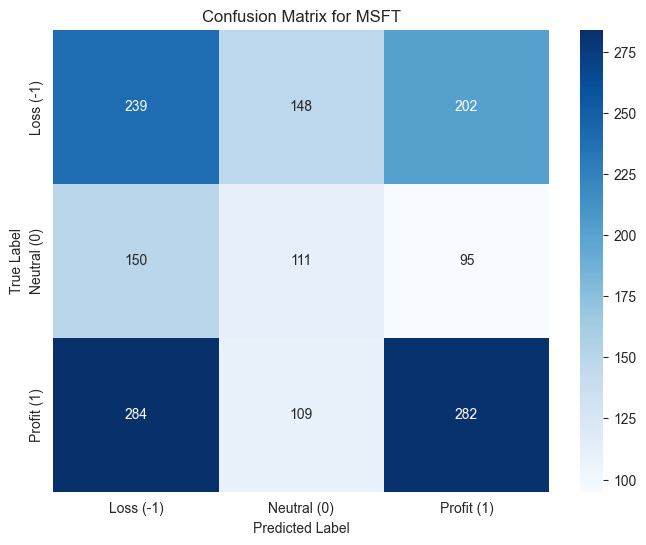

------GOOGL-----
Selected features for GOOGL:
Running for GOOGL with selected features (21)
 WALK-FORWARD RESULTS for GOOGL

--- Summary ---
      accuracy  precision    recall   roc_auc
Mean  0.419712   0.447767  0.419712  0.593265

--- Detailed Classification Report (Whole Period) ---
              precision    recall  f1-score   support

        -1.0       0.42      0.56      0.48       618
         0.0       0.34      0.24      0.28       379
         1.0       0.46      0.39      0.42       623

    accuracy                           0.42      1620
   macro avg       0.41      0.40      0.39      1620
weighted avg       0.42      0.42      0.41      1620


 BLOCK BOOTSTRAP for GOOGL
95% CI accuracy: [0.3883, 0.4574]
Bootstrap mean accuracy: 0.4218


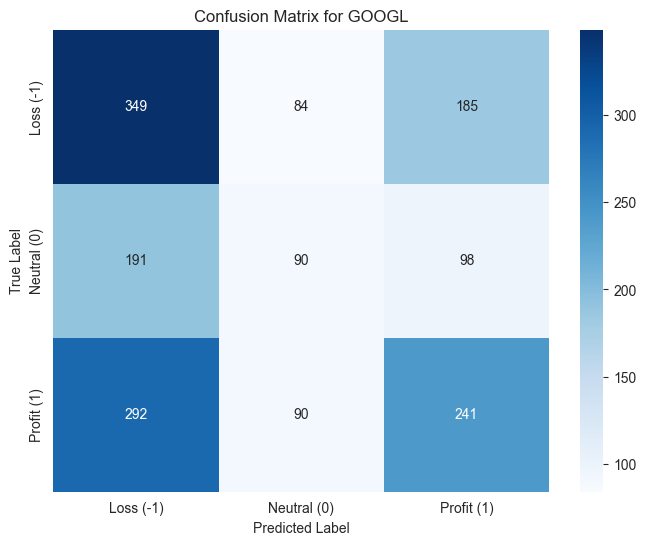

In [49]:
output = {}
with open("../../selected_features/feature_dict_tbm.json", "r") as f:
    feature_dict = json.load(f)

for share in tickers:
    data = pd.read_csv(f"../../data/all_data/all_{share}_data.csv")
    df_tmp = get_tbm_target(data, share)
    features = get_all_features(df_tmp)
    print(f"------{share}-----")
        
    selected_features = feature_dict[share]
    print(f"Selected features for {share}:")
    # print(f"Running for {share} with all features ({len(features)})")
    # run_stage4_for_ticker(data, share, features_aapl)
    print(f"Running for {share} with selected features ({len(selected_features)})")
    df, acc_smples, result = run_stage4_for_ticker(data, share, selected_features, model_version=build_ensemble_model_vote, target_type="tbm")
    output[share] = result
    

In [39]:
print(output)

with open("../results/best_result.json", "w") as f:
        json.dump(output, f, indent=2, default=json_converter)


{'AAPL': {'AAPL': {'summary':       accuracy  precision    recall   roc_auc
Mean  0.393773   0.384804  0.393773  0.535423, 'Bootstrap mean accuracy': np.float64(0.3926574074074074)}}, 'MSFT': {'MSFT': {'summary':       accuracy  precision    recall   roc_auc
Mean  0.389308   0.436017  0.389308  0.595517, 'Bootstrap mean accuracy': np.float64(0.38968395061728395)}}, 'GOOGL': {'GOOGL': {'summary':       accuracy  precision    recall   roc_auc
Mean  0.411039   0.424929  0.411039  0.579018, 'Bootstrap mean accuracy': np.float64(0.41309197530864195)}}}


## Comparison

In [61]:
from Baseline_model.baselines import get_lr_model, get_rf_model, get_xgboost_model, get_dummy_model, get_svm_model

aapl_with_features = pd.read_csv('../../data/all_data/all_AAPL_data.csv')
googl_with_features = pd.read_csv('../../data/all_data/all_GOOGL_data.csv')
msft_with_features = pd.read_csv('../../data/all_data/all_MSFT_data.csv')

tickers = ['AAPL', 'GOOGL', 'MSFT']
data_dict = {
    'AAPL': aapl_with_features,
    'GOOGL': googl_with_features,
    'MSFT': msft_with_features
}
color_dict = {
     'AAPL': 'grey',
    'GOOGL': 'yellow',
    'MSFT': 'green'
}

models_to_test = {
    'XGBoost': get_xgboost_model,
    'SVM': get_svm_model,
    'RandomForest': get_rf_model,
    'LogReg': get_lr_model,
    'Baseline_AlwaysBuy': get_dummy_model
}

all_results_comparison = {}


for ticker in tickers:
    all_results_comparison[ticker] = {}
    df_raw = data_dict[ticker]

    df_target = get_tbm_target(df_raw, ticker, pt_sl=[1.3, 1.0])
    
    df_target['Target'] = df_target['Target'].map({-1.0: 0, 0.0: 1, 1.0: 2})
    
    selected_features = feature_dict.get(ticker, [])
    
    if not selected_features:
        features_to_exclude = ['Target', 'DATE', 'index'] + [c for c in df_target.columns if 'Target' in c]
        selected_features = [c for c in df_target.columns if c not in features_to_exclude and np.issubdtype(df_target[c].dtype, np.number)]

    for model_name, model_func in models_to_test.items():
        
        folds_df, y_true, y_pred, y_proba = walk_forward_validation_with_purging(
                df=df_target,
                features=selected_features,
                model_version=model_func,
                target_col="Target",
                date_col="DATE",
                start_year=2010,       
                first_train_end_year=2015,
                last_test_year=2023
        )
            
        if not folds_df.empty:
            mean_metrics = folds_df[['accuracy', 'precision', 'recall', 'roc_auc']].mean()
            print(f"    Result {model_name}: Acc={mean_metrics['accuracy']:.3f}, Prec={mean_metrics['precision']:.3f}, Recall={mean_metrics['recall']:.3f}, AUC={mean_metrics['roc_auc']:.3f}")
                
            all_results_comparison[ticker][model_name] = mean_metrics

summary_data = []

for ticker, models_res in all_results_comparison.items():
    if models_res: 
        row = {'Ticker': ticker}
        for model_name, metrics in models_res.items():
            row[model_name] = metrics['precision']
        summary_data.append(row)

if summary_data:
    df_summary = pd.DataFrame(summary_data)
    display(df_summary) if 'display' in locals() else print(df_summary)


    Result XGBoost: Acc=0.383, Prec=0.356
    Result SVM: Acc=0.383, Prec=0.385
    Result RandomForest: Acc=0.420, Prec=0.387
    Result LogReg: Acc=0.370, Prec=0.404
    Result Baseline_AlwaysBuy: Acc=0.198, Prec=0.041
    Result XGBoost: Acc=0.401, Prec=0.423
    Result SVM: Acc=0.376, Prec=0.355
    Result RandomForest: Acc=0.420, Prec=0.420
    Result LogReg: Acc=0.397, Prec=0.418
    Result Baseline_AlwaysBuy: Acc=0.234, Prec=0.056
    Result XGBoost: Acc=0.391, Prec=0.369
    Result SVM: Acc=0.383, Prec=0.433
    Result RandomForest: Acc=0.413, Prec=0.450
    Result LogReg: Acc=0.363, Prec=0.401
    Result Baseline_AlwaysBuy: Acc=0.220, Prec=0.053
  Ticker   XGBoost       SVM  RandomForest    LogReg  Baseline_AlwaysBuy
0   AAPL  0.355655  0.385300      0.387466  0.403875            0.040825
1  GOOGL  0.423246  0.354590      0.420471  0.418441            0.056054
2   MSFT  0.369190  0.433008      0.450148  0.401309            0.052648


In [66]:
with open('../results/best_result.json', 'r') as f:
        main_model_data = json.load(f)

final_data = []

for ticker, models in all_results_comparison.items():
    for model_name, metrics in models.items():
        final_data.append({
            'Ticker': ticker,
            'Model': model_name,
            'Accuracy': metrics['accuracy'],
            'Precision': metrics['precision'],
            'Recall': metrics['recall'],
            'ROC_AUC': metrics['roc_auc']
        })

for ticker in tickers:
    if ticker in main_model_data:
        data_node = main_model_data[ticker]
        if ticker in data_node: 
            data_node = data_node[ticker]
            
        summary = data_node.get('summary', {})
            
        final_data.append({
            'Ticker': ticker,
            'Model': 'Main Model (TBM)',
            'Accuracy': summary['accuracy']['Mean'],
            'Precision': summary['precision']['Mean'],
            'Recall': summary['recall']['Mean'],
            'ROC_AUC': summary['roc_auc']['Mean']
            })
        
        
df_final_comparison = pd.DataFrame(final_data)
df_pivot = df_final_comparison.pivot(index='Ticker', columns='Model', values='Precision')
display(df_pivot.style.background_gradient(cmap='Greens', axis=1).format("{:.2%}")) if 'display' in locals() else print(df_pivot)

df_detailed = df_final_comparison.sort_values(by=['Ticker', 'Precision'], ascending=[True, False])
display(df_detailed) if 'display' in locals() else print(df_detailed)
    
df_final_comparison.to_csv('../results/final_comparison_all_models.csv', index=False)

Model   Baseline_AlwaysBuy    LogReg  Main Model (TBM)  RandomForest  \
Ticker                                                                 
AAPL              0.040825  0.403875          0.384804      0.387466   
GOOGL             0.056054  0.418441          0.424929      0.420471   
MSFT              0.052648  0.401309          0.436017      0.450148   

Model        SVM   XGBoost  
Ticker                      
AAPL    0.385300  0.355655  
GOOGL   0.354590  0.423246  
MSFT    0.433008  0.369190  
   Ticker               Model  Accuracy  Precision    Recall   ROC_AUC
3    AAPL              LogReg  0.370477   0.403875  0.370477  0.556188
2    AAPL        RandomForest  0.419693   0.387466  0.419693  0.517861
1    AAPL                 SVM  0.383421   0.385300  0.383421  0.527082
15   AAPL    Main Model (TBM)  0.393773   0.384804  0.393773  0.535423
0    AAPL             XGBoost  0.382757   0.355655  0.382757  0.514083
4    AAPL  Baseline_AlwaysBuy  0.198044   0.040825  0.198044  0.5000